## Regressió Logística

**Nom**: 

La **regressió logística** és un tipus d'algorisme de classificació binària (vol predir un valor $0$ o $1$ per una determinada mostra) i per fer-ho fa servir la funció logística:

$$ \sigma(x) = \frac{1}{1+ e^{-x}}  $$

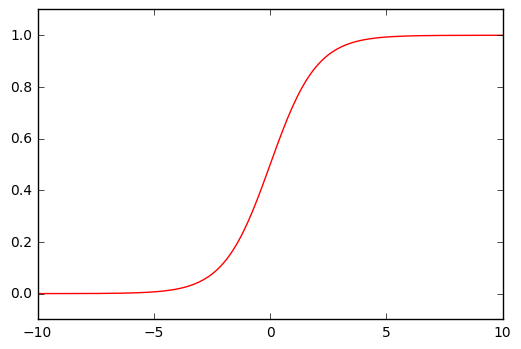

In [2]:
import math
import numpy as np

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

x = np.linspace(-10,10,200)
y = [logistic(_) for _ in x]

%matplotlib inline
import matplotlib.pyplot as plt
axes = plt.gca()
axes.set_ylim([-0.1,1.1])
plt.plot(x,y,'r')
plt.show()

Si disposem d'un conjunt de punts $\{(x_i, y_i)\}$, on $y_i \in \{0,1\}$, i volem trobar quina és la probabilitat d'una mostra de ser $0$ o $1$ podem aproximar la probabilitat d'aquesta manera:

$$ \hat{y}_i = \sigma(w x_i) $$

on $w$ són una sèrie de pesos que cal determinar. En el cas de la regressió logísitica, la funció de cost que MAXIMITZAREM és la funció que s'anomena *log likelihood*:

$$ logL = y_i \log \sigma(w x_i) + (1- y_i) \log (1 - \sigma(w x_i))$$

In [3]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i == 1:
        return math.log(logistic(dot(x_i, beta)))
    else:
        return math.log(1 - logistic(dot(x_i, beta)))

Per tant, la funció de cost és:

$$ \sum_{x_i, y_i} y_i \log \sigma(w x_i) + (1- y_i) \log (1 - \sigma(w x_i)) $$

In [4]:
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta)
               for x_i, y_i in zip(x, y))

Les derivades d'aquestes funcions són simples:

In [5]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """j es l'index de la derivada"""
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]
    
def logistic_log_gradient_i(x_i, y_i, beta):
    """gradient de log likelihood pel punt i"""
    return [logistic_log_partial_ij(x_i, y_i, beta, j)
            for j, _ in enumerate(beta)]
            
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add,
                  [logistic_log_gradient_i(x_i, y_i, beta)
                   for x_i, y_i in zip(x,y)])    

Amb això, i algunes funcions auxililars, tenim tots els ingredients per plantejar el problema com un problema d'optimització.

In [6]:
# funcions auxiliars
from functools import partial

def split_data(data, prob):
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def train_test_split(x, y, test_pct):
    data = zip(x, y)                                
    train, test = split_data(data, 1 - test_pct)  
    x_train, y_train = zip(*train)                
    x_test, y_test = zip(*test)
    return x_train, x_test, y_train, y_test

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0, 
                          tolerance)

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing
    
    while True:
        gradient = gradient_fn(theta)  
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
                   
        # choose the one that minimizes the error function        
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
            
def rescale(data_matrix):
    means, stdevs = scale(data_matrix)

    def rescaled(i, j): 
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def mean(x): 
    return sum(x) / len(x)

def get_column(A, j):
    return [A_i[j] for A_i in A]

def variance(x):
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)
    
def standard_deviation(x):
    return math.sqrt(variance(x))

def de_mean(x):
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix 
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]  

def entry_fn(i, j): return A[i][j] + B[i][j]

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

Les dades que farem servir corresponen a una base de dades de 200 usuaris i contenen els seus anys d'experiència, el seu salari i el resultat d'una avaluació interna ($0$ o $1$). 

In [7]:
data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0), \
        (8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0), \
        (1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),   \
        (6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),\
        (8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),\
        (0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),\
        (0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),\
        (8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0), \
        (1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),\
        (7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),\
        (8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),\
        (4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),\
        (8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),\
        (2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),\
        (8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),\
        (2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),\
        (2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),\
        (7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),\
        (8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),\
        (5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),\
        (4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),\
        (4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),\
        (3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),\
        (8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),\
        (1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),\
        (9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),\
        (7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),\
        (2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),\
        (5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]
data = map(list, data)              # canviem de tuples a llistes
x = [[1] + row[:2] for row in data] # cada element es [1, experiencia, salari]
y = [row[2] for row in data]        # cada element es resultat
print x[0:2], y[0:2]

[[1, 0.7, 48000], [1, 1.9, 48000]] [1, 0]


El fet de posar una de les components de $x_i$ a $1$ ens permet que el model lineal que usem pugui ser del tipus $w_0 + w_1 x_1 + w_2 x_2$, atès que $x_0 = 1$.

In [8]:
import random
random.seed(0)
rescaled_x = rescale(x)
x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# want to maximize log likelihood on the training data
fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# pick a random starting point
w_0 = [1, 1, 1]

# and maximize using gradient descent
w_hat = maximize_batch(fn, gradient_fn, w_0)

print "w_hat", w_hat

w_hat [-1.9061824826642335, 4.053083869380028, -3.878895361783912]


## Exercici 1

Avalua el resultat anterior en termes de 'precision' i 'recall'. Consulteu https://en.wikipedia.org/wiki/Precision_and_recall 

In [ ]:
# Solució

## Exercici 2

Feu un gràfic en que l'eix $x$ representi el valor de les prediccions i el $y$ els valors reals.

In [9]:
# Solució

## Exercici 3

El cas anterior surt d'un nombre random fix (random.seed(0)) i d'un paràmetre fix ([1,1,1]). Feu una cerca aleatoria a veure si es pot trobar un `w_hat` sensiblement millor al [-1.9061824826642335, 4.053083869380028, -3.878895361783912].

In [ ]:
# Solució